In [1]:
%matplotlib inline 
%config InlineBackend.figure_format = 'retina'
import numpy as np 
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import time 
from tqdm.notebook import tqdm

In [2]:
from path_overlap import * 

In [3]:
num_dense, num_sparse = 10, 10
tot_units = num_dense + num_sparse
density = 1
num_layers = 2
MPG = multipartite_network(num_layers, num_dense, num_sparse, density)

In [4]:
pos = nx.multipartite_layout(MPG)

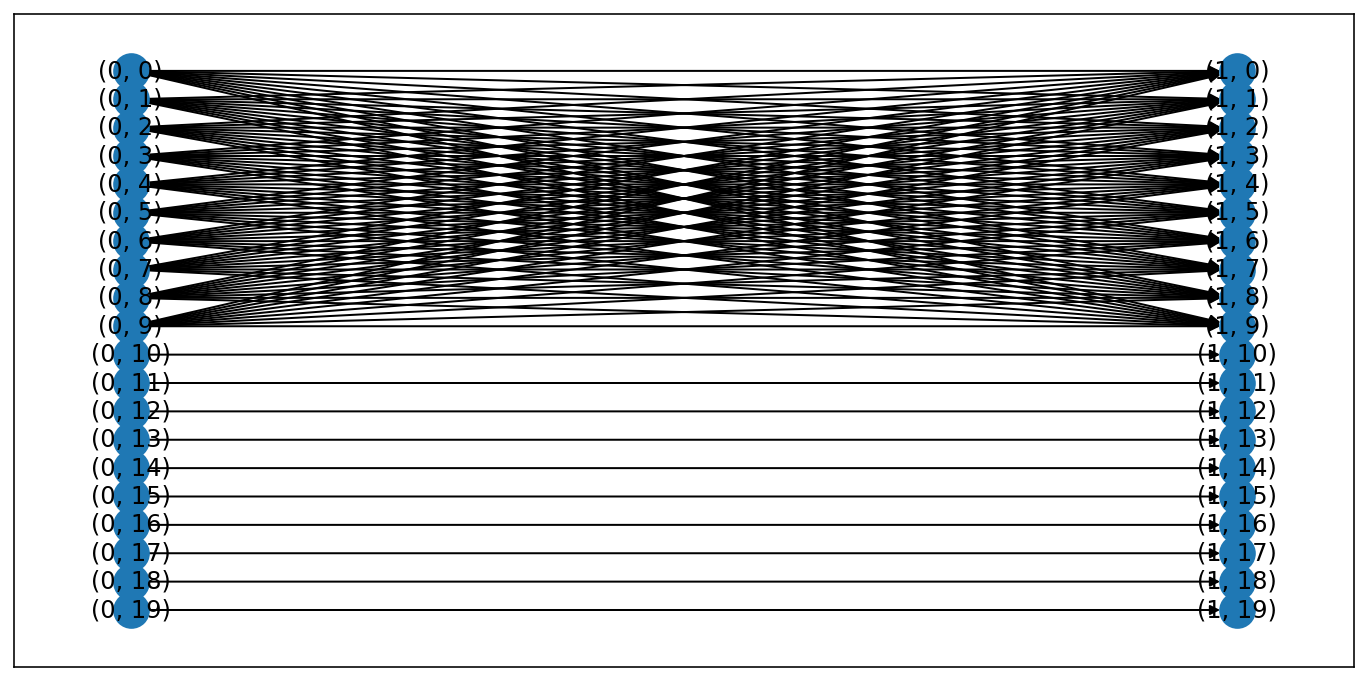

In [5]:
fig = plt.figure(figsize=(12,6))
nx.draw_networkx(MPG, pos)

In [6]:
rew_MPG, counts = rewire_multipartite_network(MPG, tot_units, rewire_prob=.9, verbose=True, rewire_iters=100)

In [7]:
rew_pos = nx.multipartite_layout(rew_MPG)

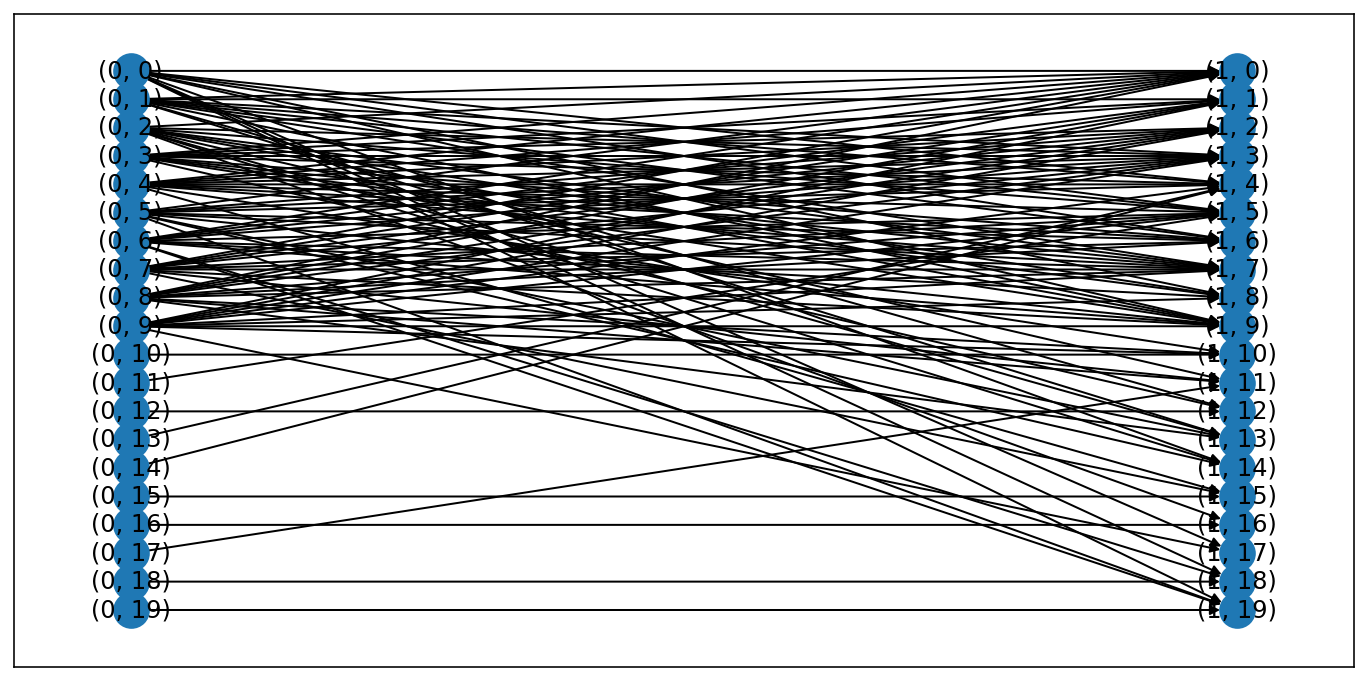

In [8]:
fig = plt.figure(figsize=(12,6))
nx.draw_networkx(rew_MPG, pos)

In [9]:
from itertools import combinations, product
output_nodes = [(3, x) for x in range(tot_units)]
input_nodes = [(0, x) for x in range(tot_units)]

paths = {}
for n, nn in product(input_nodes, output_nodes):
    paths[(n, nn)] = list(nx.all_simple_paths(MPG, n, nn));
    
rew_paths = {}
for n, nn in product(input_nodes, output_nodes):
    rew_paths[(n, nn)] = list(nx.all_simple_paths(rew_MPG, n, nn));

In [10]:
path_families = [paths[(0,0), (3,0)], paths[(0,5), (3,5)]]
for k1, k2 in combinations(paths.keys(),2):
    if HO_interference([paths[k1], paths[k2]], rew_MPG)!= layer_interference_overlap(rew_MPG, paths[k1], paths[k2]):
        print(k1, k2)

In [11]:
for k1, k2 in combinations(rew_paths.keys(),2):
    if HO_interference([paths[k1], paths[k2]], rew_MPG)!= layer_interference_overlap(rew_MPG, paths[k1], paths[k2]):
        print(k1, k2)

In [12]:
IG, rew_IG = MP_interference_graph(MPG), MP_interference_graph(rew_MPG)

In [13]:
IG.number_of_edges(), rew_IG.number_of_edges()

(4950, 4567)

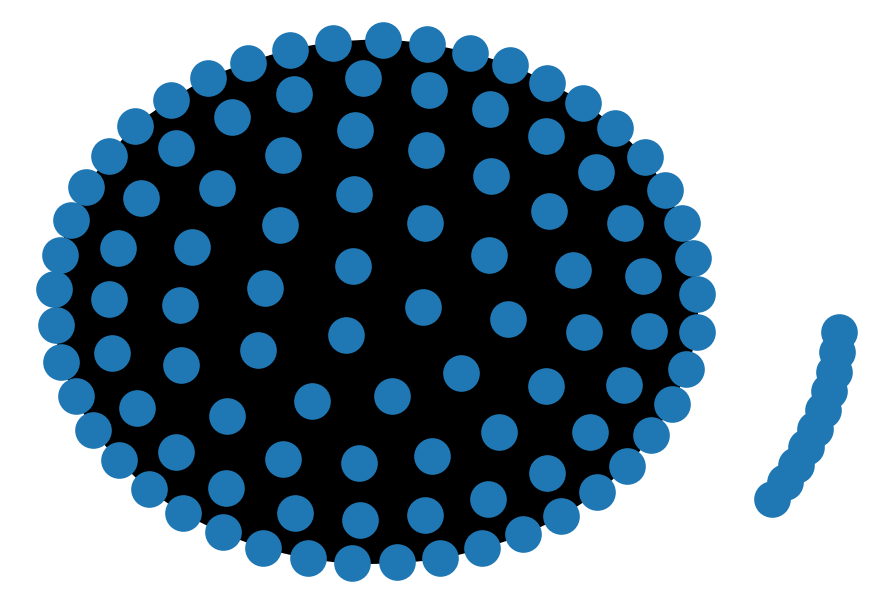

In [14]:
nx.draw_kamada_kawai(IG)

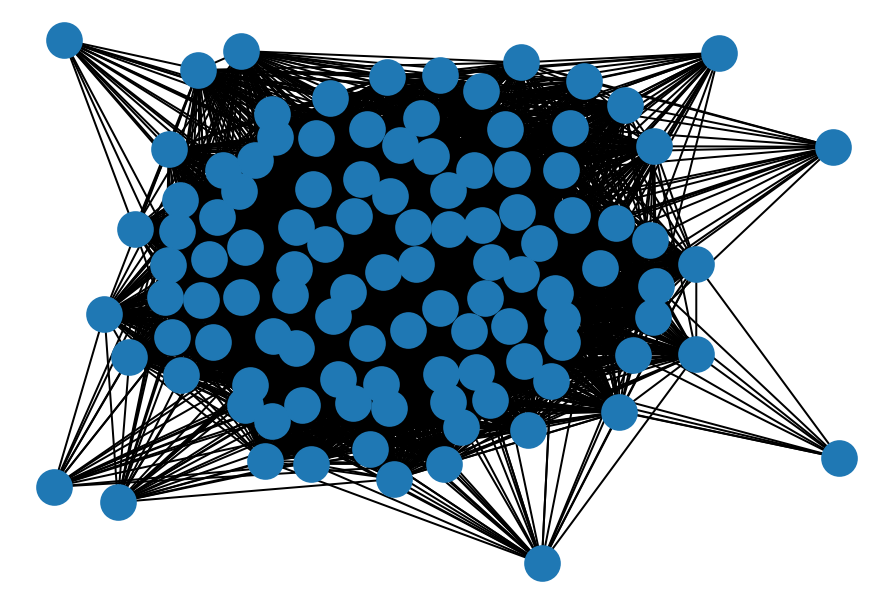

In [15]:
nx.draw_kamada_kawai(rew_IG)

In [16]:
num_iterations = 50
rw_it = 5
IG_dict = {}
IG_dict[0] = IG
instant_rew_MPG = MPG.copy()
counts = [0]
for it in tqdm(range(1, num_iterations)):
    instant_rew_MPG, instant_counts = rewire_multipartite_network(
        instant_rew_MPG, tot_units, rewire_prob=1, rewire_iters=rw_it, verbose=True)
    counts.append(counts[-1]+instant_counts)
    IG_dict[it] = MP_interference_graph(instant_rew_MPG)

In [17]:
tot_interference = [len(nx.maximal_independent_set(IG_dict[x])) for x in range(num_iterations)]

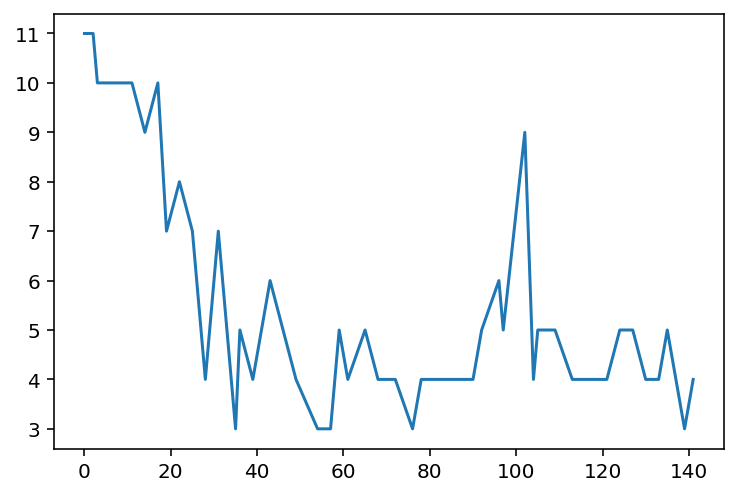

In [31]:
plt.plot(counts, np.array(tot_interference))

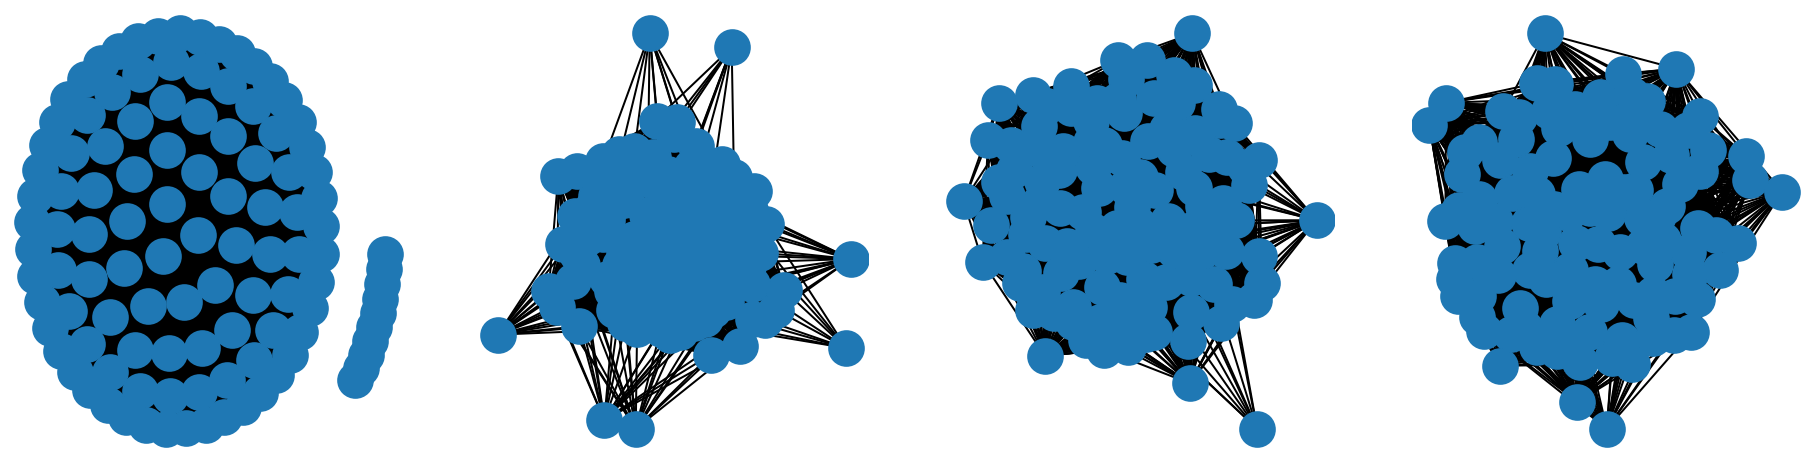

In [19]:
fig = plt.figure(figsize=(16, 4))
for i, n in enumerate([0, 10, 30, 45]):
    plt.subplot(1, 4, i+1);
    nx.draw_kamada_kawai(IG_dict[n])

## measure the reconstructed MIS vs the sampled MIS 

In [20]:
def line_graph(G):
    ig = nx.Graph();
    for n in G.nodes():
        new_nodes = []
        for nn in G.neighbors(n):
            new_nodes.append(str(sorted(tuple([n,nn]))));
            ig.add_node(str(sorted(tuple([n,nn]))));
        from itertools import combinations
        for co in combinations(new_nodes,2):
            ig.add_edge(co[0],co[1])
    return ig;

def interference_graph(ig):
    g = ig.copy();
    new_edges = [];
    for i in list(ig.nodes()):
        for j in list(ig.nodes()):
            try:
                if nx.shortest_path_length(ig,i,j)==2:
                    new_edges.append([i,j]);
            except:
                pass;
    g.add_edges_from(new_edges);
    return g;

In [21]:
num_iterations = 50
rw_it = 5
IG_dict = {}
IG_dict[0] = IG
instant_rew_MPG = MPG.copy()
counts = [0]
MP_mis, old_mis = [], []
for it in tqdm(range(1, num_iterations)):
    instant_rew_MPG, instant_counts = rewire_multipartite_network(
        instant_rew_MPG, tot_units, rewire_prob=1, rewire_iters=rw_it, verbose=True)
    counts.append(counts[-1]+instant_counts)
    IG_dict[it] = MP_interference_graph(instant_rew_MPG)
    MP_mis.append(len(nx.maximal_independent_set(IG_dict[it])));
    old_mis.append(len(nx.maximal_independent_set(interference_graph(line_graph(nx.Graph(instant_rew_MPG))))))

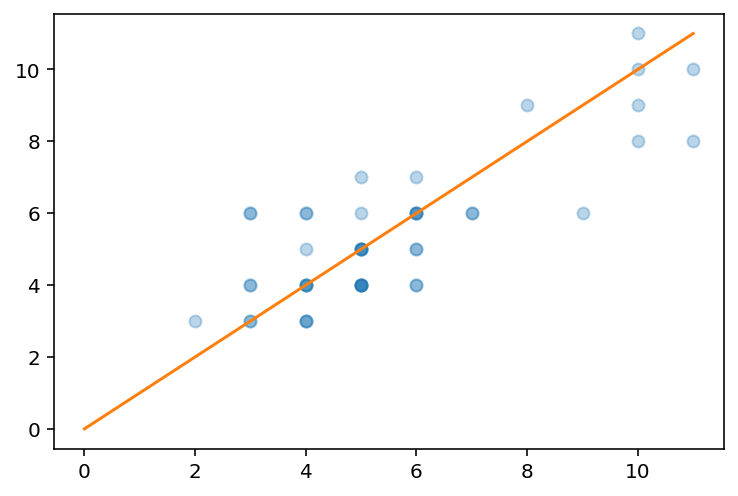

In [22]:
plt.plot(MP_mis, old_mis, 'o', alpha=.3)
plt.plot(range(np.max(MP_mis)+1), range(np.max(MP_mis)+1))

In [92]:
from scipy.stats import pearsonr
pearsonr(old_mis, MP_mis)

(0.7561567537667646, 3.333473817497462e-10)

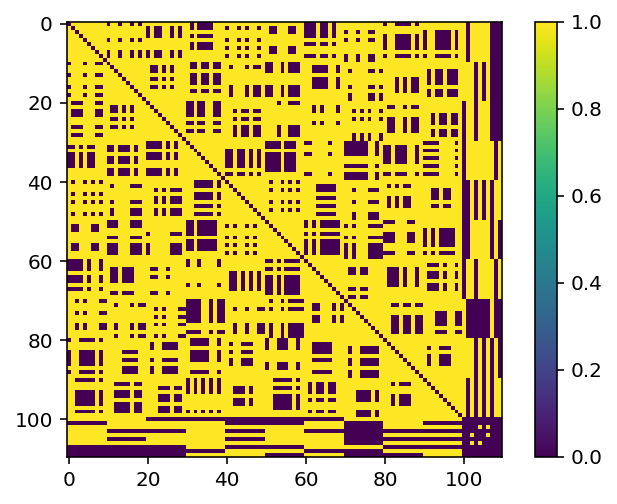

In [30]:
plt.imshow(nx.adjacency_matrix(IG_dict[45]).todense())
plt.colorbar()